In [4]:
import torch
import numpy as np
from dataclasses import dataclass, field
from typing import List, Tuple
import matplotlib.pyplot as plt

@dataclass
class Configs:
    
    #...general params:
    workdir : str = '../../results/colored_gauss_test/'   
    device : str = 'cuda:0'
    multi_gpu : bool = False

    #...data params:
    data : str = None
    target : str = 'Ngaussians'
    source : str = 'noise'
    vocab_size : int = 8
    dim_continuous : int = 2
    dim_discrete : int = 1
    
    # #...model params:
    model : str = 'mlp'
    num_layers : int = 4
    dim_hidden : int = 128 
    dim_time_emb : int = 16
    time_embedding  : str = 'sinusoidal'     
    dropout : float = 0.1
    activation : str = 'GELU'

    #...training params:
    batch_size : int = 128
    data_split_frac : List[float] = field(default_factory = lambda : [0.8, 0.2, 0.0])  # train / val / test 
    epochs: int = 20
    early_stopping : int = None
    min_epochs : int = None 
    print_epochs : int = None   
    num_workers : int = 0
    pin_memory: bool = False

    #...cfm params:
    dynamics : str = 'CFM'
    sigma: float = 0.001

    #...optimization & scheduler params:
    optimizer: str = 'Adam'
    lr : float = 2e-4
    weight_decay : float = 0.0
    optimizer_betas : List[float] = field(default_factory = lambda : [0.9, 0.999])
    optimizer_eps : float = 1e-8
    optimizer_amsgrad : bool = False
    gradient_clip : float = None
    scheduler: str = None
    scheduler_t_max: int = None
    scheduler_eta_min: float = None
    scheduler_gamma: float = None
    scheduler_step_size: int = None

    #...generation pipeline params:
    sampler : str = 'EulerSolver'
    solver = 'euler'
    num_timesteps : int = 100
    time_eps : float = 1e-3

    def __post_init__(self):
        self.data = self.source + '_to_' + self.target
        self.dim_continuous = len(self.feature_continuous)
        self.dim_discrete = len(self.feature_discrete) 
        self.dim_context = len(self.feature_context)
        if self.multi_gpu: self.device = 'cuda:0'
        if self.dim_discrete == 0: self.dim_discrete_emb = 0


def plot_trajectories(traj, labels, N=100000):
    """Plot trajectories of some selected samples."""
    plt.figure(figsize=(4, 4))
    for i in range(traj.shape[0]): 
        plt.scatter(traj[i, :N, 0], traj[i, :N, 1], s=.01, alpha=.05, c=labels.unsqueeze(1)[:N] if conf.DIM_CONTEXT else 'k', cmap = 'tab10')
    plt.scatter(traj[0, :N, 0], traj[0, :N, 1], s=1, alpha=1, c=labels.unsqueeze(1)[:N] if conf.DIM_CONTEXT else 'b', cmap = 'tab10')
    plt.scatter(traj[-1, :N, 0], traj[-1, :N, 1], s=1, alpha=1, c=labels.unsqueeze(1)[:N] if conf.DIM_CONTEXT else 'r', cmap = 'tab10')
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
    plt.show()

# Data

In [2]:
from cmb.data.gaussians import EightGaussiansDataClass
from cmb.data.utils import DefineDataloader

conf = Configs()
gauss = EightGaussiansDataClass(conf, num_gaussians=8, num_points_per_gaussian=8000, std_dev=0.1)
dataloader = DefineDataloader(gauss)

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 51200, validation size: 12800, testing sizes: 0


In [3]:
# gauss.target.shape
# plt.figure(figsize=(4, 4))
# plt.scatter(gauss.target[:, 0], gauss.target[:, 1], s=1, c=gauss.context if conf.DIM_CONTEXT else 'b', cmap = 'tab10')
# plt.scatter(gauss.source[:, 0], gauss.source[:, 1], s=1, c=gauss.context if conf.DIM_CONTEXT else 'r', cmap = 'tab10')
# plt.xticks([])
# plt.yticks([])
# plt.axis('equal')
# plt.show()

# Train CFM

In [4]:
from cmb.dynamics.cmb import ConditionalMarkovBridge
from cmb.models.architectures.deep_nets import MixedMLP
from cmb.models.trainers import CMBTrainer

dynamics = ConditionalMarkovBridge(conf)
mmlp = MixedMLP(conf)
model = CMBTrainer(dynamics, mmlp, gauss)
model.train()

2024-08-08 09:46:31.404756: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 09:46:31.443705: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 09:46:31.444481: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 09:46:32.127049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
number of training parameters: 58042
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 51200, validation size: 12800, testing sizes: 0


epochs:   0%|          | 0/20 [00:00<?, ?it/s]

### Generating data

In [2]:
import torch
from dataclasses import dataclass
from torch.nn.functional import softmax

class DriftRateModel(torch.nn.Module):
    def __init__(self, model, config):
        super().__init__()
        self.model = model # model should output logits
        self.vocab_size = config.VOCAB_SIZE
        self.config = config
        self.gamma = config.GAMMA

    def forward(self, t, x, s, context=None):
        t = t.squeeze()
        if len(s.shape) != 2:
            s = s.reshape(s.size(0),-1)
        drift, logits = self.model(t, x, s, context)
        t1 = 1. - self.time_epsilon
        beta_integral = (t1 - t) * self.gamma
        wt = torch.exp(-self.vocab_size * beta_integral)
        A, B, C = 1. , (wt * self.vocab_size)/(1. - wt) , wt
        qx = softmax(logits, dim=2)
        qy = torch.gather(qx, 2, s.long().unsqueeze(2))
        rate = A + B[:, None, None] * qx + C[:, None, None] * qy
        return drift, rate

class TauLeapEulerSolver:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def simulate(self, x, s, t_span):
        time_steps = len(t_span)
        tau = (t_span[-1] - t_span[0]) / (time_steps - 1)
        trajectory = [x]
        jump_trajectory = [s]
        
        for i in range(1, time_steps):
            t = t_span[i-1]
    
            state = s.clone()

            print('x={}, s={}, t={}'.format(x.shape, s.shape, t.shape))
            
            drift, rates = self.model(t, x, state).to(self.device)
            voc_size = rates.size(-1) 

            jumps = torch.poisson(rates * tau).to(self.device)  
            net_jumps = torch.argmax(jumps, dim=-1).type_as(state)
            s = torch.clamp(net_jumps, min=0, max=voc_size-1) 
            x = x + tau * drift.to(self.device)           
            jump_trajectory.append(s.clone())
            trajectory.append(x.clone())

        return torch.stack(trajectory), torch.stack(jump_trajectory)

class ContextWrapper(torch.nn.Module):
    """ Wraps model to torchdyn compatible format.
    """
    def __init__(self, net, context=None):
        super().__init__()
        self.nn = net
        self.context = context

    def forward(self, t, x, s):
        t = t.repeat(x.shape[0])
        t = self.reshape_time_like(t, x)
        print(t.shape, x.shape, s.shape)
        print(t)
        return self.nn(t, x, s, context=self.context)
    
    def reshape_time_like(self, t, x):
        if isinstance(t, (float, int)): return t
        else: return t.reshape(-1, *([1] * (x.dim() - 1)))


class CMBPipeline:
    
    def __init__(self, 
                 trained_model, 
                 config: dataclass=None,
                 best_epoch_model: bool=True,
                 ):

        self.config = config
        self.model = trained_model.best_epoch_model if best_epoch_model else trained_model.last_epoch_model
        self.num_sampling_steps = config.NUM_SAMPLING_STEPS
        self.sampler = config.SAMPLER
        self.device = config.DEVICE
        self.vocab_size = config.VOCAB_SIZE
        self.has_context = True if config.DIM_CONTEXT > 0 else False
        self.time_steps = torch.linspace(0.0, 1.0, self.num_sampling_steps, device=self.device)

    @torch.no_grad()
    def generate_samples(self, source_continuous, source_discrete, context=None):
        self.source_continuous = source_continuous.to(self.device) 
        self.source_discrete = source_discrete.to(self.device)
        self.jumps = self.MarkovSolver() 

    @torch.no_grad()
    def MarkovSolver(self):
        mixed_model = DriftRateModel(self.model, self.config)
        mixed_model = ContextWrapper(mixed_model, context=None)
        solver = TauLeapEulerSolver(mixed_model, device=self.device)        
        return solver.simulate(x=self.source_continuous, s=self.source_discrete, t_span=self.time_steps).detach().cpu()



In [3]:
# from cmb.models.pipelines import CMBPipeline

pipeline = CMBPipeline(trained_model=model, config=conf)
positions = torch.randn(8000, 2) * 0.1
labels = torch.randint(low=0, high=8, size=(positions.shape[0],))

pipeline.generate_samples(source_continuous=positions, source_discrete=labels.unsqueeze(1))

plot_trajectories(pipeline.trajectories, labels, N=5000)

NameError: name 'model' is not defined

# Train Schrodinger Bridge

In [14]:
from cmb.dynamics.cfm import SBCFM
from cmb.models.architectures.deep_nets import MLP
from cmb.models.trainers import CFMTrainer

dynamics = SBCFM(conf)
mlp = MLP(conf)
model = CFMTrainer(dynamics, mlp, gauss)
model.train()


number of training parameters: 19842
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 51200, validation size: 12800, testing sizes: 0


epochs:   0%|          | 0/20 [00:00<?, ?it/s]

## $\sigma=10^{-6}$

### without SB-OT

INFO: EulerSolver with euler method and steps=200


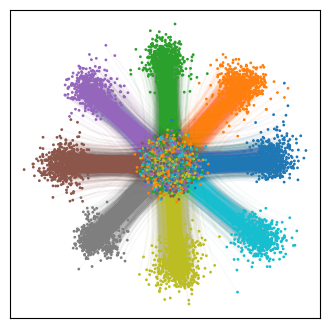

In [6]:
from cmb.models.pipelines import CFMPipeline

input_source = torch.randn(8000, 2) * 0.1
labels = torch.randint(low=0, high=8, size=(input_source.shape[0],))

pipeline = CFMPipeline(trained_model=model, config=conf)
pipeline.generate_samples(input_source, context=labels.unsqueeze(1))
plot_trajectories(pipeline.trajectories, labels, N=5000)

## $\sigma=0.1$

INFO: EulerSolver with euler method and steps=200


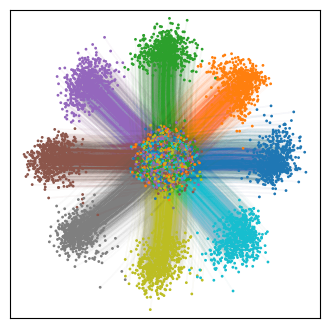

In [15]:
from cmb.models.pipelines import CFMPipeline

pipeline = CFMPipeline(trained_model=model, config=conf)

input_source = torch.randn(8000, 2) * 0.1
labels = torch.randint(low=0, high=8, size=(input_source.shape[0],))

pipeline.generate_samples(input_source, context=labels.unsqueeze(1))
plot_trajectories(pipeline.trajectories, labels, N=5000)

## $\sigma=1.0$

INFO: EulerSolver with euler method and steps=200


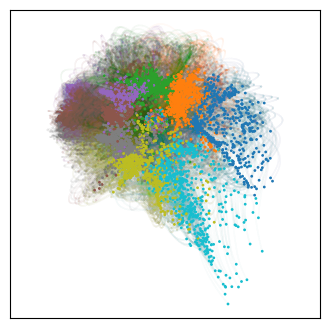

In [10]:
from cmb.models.pipelines import CFMPipeline

pipeline = CFMPipeline(trained_model=model, config=conf)

input_source = torch.randn(8000, 2) * 0.1
labels = torch.randint(low=0, high=8, size=(input_source.shape[0],))

pipeline.generate_samples(input_source, context=labels.unsqueeze(1))
plot_trajectories(pipeline.trajectories, labels, N=5000)